In [1]:
import sys
sys.path.append('lib/src/')
import torch
from torch import nn
import os
import numpy as np
from matplotlib import pyplot as plt

from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs, My_Dataset, My_MaskedDataset, make_batched_masks
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.samplers.normal_sampling import NormalSampler
from lib.src.pythae.samplers.manifold_sampler import RHVAESampler

sys.path.append('diffusion/stable_diffusion/')
sys.path.append('diffusion/stable_diffusion/model/')
from diffusion.stable_diffusion.latent_diffusion import LatentDiffusion, DiffusionWrapper, MyLatentDiffusion
from diffusion.stable_diffusion.model.autoencoder import Autoencoder
from diffusion.stable_diffusion.model.clip_embedder import CLIPTextEmbedder
from diffusion.stable_diffusion.model.unet import UNetModel, _test_time_embeddings

%reload_ext autoreload
%autoreload 2

In [2]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
train_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_train.pt'))[:-1000, -1, :, :, :].to(device) #only keeping the last frame of each sequence
eval_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_train.pt'), map_location="cpu")[-1000:, -1, :, :, :].to(device)
test_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, -1, :, :, :].to(device)
print(train_data.shape)
train_data = train_data.permute(0, 3, 1, 2)
eval_data = eval_data.permute(0, 3, 1, 2)
test_data = test_data.permute(0, 3, 1, 2)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool).to(device)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool).to(device)
test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

torch.Size([8000, 64, 64, 3])
torch.Size([8000, 3, 64, 64])


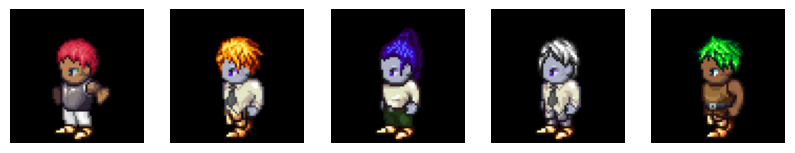

In [3]:
#check
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_dataset[i][0].data.cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [4]:
input_dim = (3, 64, 64)
f = 8 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)

training_config = BaseTrainerConfig(output_dir='my_model',
num_epochs=100,
learning_rate=1e-3,
per_device_train_batch_size=200,
per_device_eval_batch_size=200,
train_dataloader_num_workers=2,
eval_dataloader_num_workers=2,
steps_saving=50,
optimizer_cls="AdamW",
optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
scheduler_cls="ReduceLROnPlateau",
scheduler_params={"patience": 5, "factor": 0.5})


Latent dim: 192


In [5]:
device = 'cuda'
vae = VAE.load_from_folder('pre-trained_vae/VAE_training_2024-05-22_14-43-10/final_model').to(device)
# out = vae(train_dataset[:-1].to(device))
# print(out.reconstruction_loss)
# print(out.reg_loss)

In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=200, shuffle=True)
val_loader = torch.utils.data.DataLoader(eval_data, batch_size=200, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=200, shuffle=True)


# mu = []
# log_var = []
# with torch.no_grad():
#     for _ , x in enumerate(train_loader):

#         data = x.data

#         out = vae.encoder(data.to(device))

#         mu_data, log_var_data = out.embedding, out.log_covariance

#         mu.append(mu_data)
#         log_var.append(log_var_data)

# mu = torch.cat(mu)
# log_var = torch.cat(log_var)

x = next(iter(train_loader))
x.shape

torch.Size([200, 3, 64, 64])

In [7]:

def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )

In [8]:
######## UNET #######
in_channels = 3
out_channels = 3
channels = 32
n_res_blocks = 2
attention_levels = [2]
channel_multipliers = (1, 2, 4)
n_heads = 16

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

z = torch.randn(1, 3, 8, 8)
empty_prompt_embed = None
print(unet(z, torch.tensor([10]), empty_prompt_embed).shape)
sum(p.numel() for p in unet.parameters() if p.requires_grad)

torch.Size([1, 3, 8, 8])


5721539

In [9]:
latent_scaling_factor = 1
n_steps = 1000
linear_start =  0.00085
linear_end = 0.012


latent_diffusion = MyLatentDiffusion(unet, vae, latent_scaling_factor, n_steps, linear_start, linear_end)
sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad)

7903638

In [10]:
vae = vae.to('cpu')
z = vae.encoder(x).embedding.reshape(-1, 3, 8, 8).detach()

latent_diffusion(z, torch.tensor([10])).shape


torch.Size([200, 3, 8, 8])

In [11]:
latent_diffusion.autoencoder_encode(x).shape

torch.Size([200, 192])

In [12]:
import lightning as L
import torch.functional as F

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


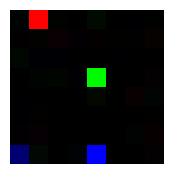

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([200, 3, 8, 8])


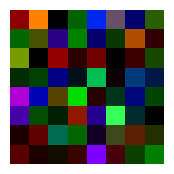

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


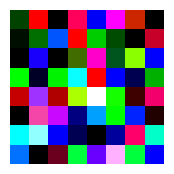

In [13]:
plt.figure(figsize=(2, 2))
plt.imshow(z[10].permute(1, 2, 0))
plt.axis('off')
plt.show()
batch_size = 200
noise = torch.randn_like(z)
print(noise.shape)
z_noisy = latent_diffusion.add_noise(z, noise, torch.randint(0, 1000, (batch_size,)))

plt.figure(figsize=(2, 2))
plt.imshow(z_noisy[10].permute(1, 2, 0))
plt.axis('off')
plt.show()

plt.figure(figsize=(2, 2))
plt.imshow(noise[12].permute(1, 2, 0))
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


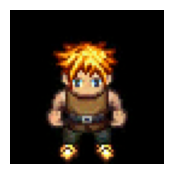

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


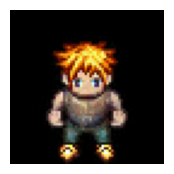

In [14]:
z_noisy = z_noisy.reshape(-1, 192).float()
out = vae.decoder(z_noisy).reconstruction

z = z.reshape(-1, 192).float()
rec = vae.decoder(z).reconstruction


plt.figure(figsize=(2, 2))
plt.imshow(rec[10].detach().permute(1, 2, 0))
plt.axis('off')
plt.show()

plt.figure(figsize=(2, 2))
plt.imshow(out[10].detach().permute(1, 2, 0))
plt.axis('off')
plt.show()


In [15]:
latent_diffusion(z_noisy.reshape(-1, 3, 8, 8), torch.randint(0, 1000, (batch_size,)))

tensor([[[[ 1.9099e-01,  6.6481e-01,  4.2013e-01,  ...,  1.9550e-01,
            2.2606e-01,  5.2943e-02],
          [ 1.2059e-01,  2.0403e-01,  3.9977e-01,  ...,  1.4248e-01,
            1.9817e-01,  1.5243e-01],
          [-1.1918e-01,  2.4099e-01,  2.1890e-01,  ..., -2.0133e-02,
           -2.5020e-01,  2.4380e-01],
          ...,
          [ 1.2024e-01,  3.5424e-01,  5.2895e-01,  ..., -5.8598e-01,
            1.7073e-02,  5.5017e-02],
          [ 1.4451e-01,  5.8986e-01, -4.3726e-01,  ..., -4.3748e-01,
           -4.0542e-01,  2.1013e-01],
          [ 6.4180e-02,  2.1402e-01, -2.8606e-01,  ...,  3.2497e-02,
            1.6850e-02,  1.7165e-01]],

         [[ 1.9226e-01,  2.0692e-01,  1.7531e-01,  ..., -2.7918e-01,
            3.1446e-01,  4.4864e-02],
          [-2.0498e-02, -1.4167e-02,  2.3800e-01,  ...,  5.5829e-02,
            3.6925e-01, -1.7675e-01],
          [-4.9445e-03,  2.3337e-01, -4.9415e-01,  ..., -3.3830e-01,
           -3.2655e-01, -2.6809e-01],
          ...,
     

In [19]:
torch.tensor([latent_diffusion.n_steps]).repeat(batch_size).shape

torch.Size([200])

In [16]:
class LitLDM(L.LightningModule):
    def __init__(self, ldm, lr = 1e-3):
        super().__init__()
        self.ldm = ldm
        self.lr = lr

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x = batch
        z = self.ldm.autoencoder.encoder(x).reshape(-1, 3, 8, 8)
        noise = torch.randn_like(z)

        t = torch.randint(0, self.ldm.n_steps, (z.shape[0],)).to(z.device)

        noisy_z = self.ldm.add_noise(z, noise, t).float()

        noise_pred = self.ldm(noisy_z, t)

        loss = nn.MSELoss()(noise_pred, noise)


        return loss
    
    def validation_step(self, batch, batch_idx):
        x = batch
        batch_size = x.shape[0]
        z = self.ldm.autoencoder.encoder(x).reshape(-1, 3, 8, 8)
        noise = torch.randn_like(z)

        t = torch.tensor([latent_diffusion.n_steps]).repeat(batch_size)

        noisy_z = self.ldm.add_noise(z, noise, t).float()

        noise_pred = self.ldm(noisy_z, t)

        val_loss = nn.MSELoss()(noise_pred, noise)

        

        self.log("val_loss", val_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer